In [1]:
import akshare as ak
import backtrader as bt
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from backtrader_plotting import Bokeh
from backtrader_plotting.schemes import Tradimo, Blackly

# plt.rcParams["font.sans-serif"] = ["SimHei"]
# plt.rcParams["axes.unicode_minus"] = False

def syl(from_:float, to:float)->float:
    return (to - from_) / from_

Loading BokehJS ...

In [68]:
# # 利用 AKShare 获取股票的后复权数据，这里只获取前 6 列
# stock_hfq_df = ak.stock_zh_a_hist(symbol="000001", adjust="hfq").iloc[:, :6]
# # 处理字段命名，以符合 Backtrader 的要求
# stock_hfq_df.columns = [
#     'date',
#     'open',
#     'close',
#     'high',
#     'low',
#     'volume',
# ]
# # 把 date 作为日期索引，以符合 Backtrader 的要求
# stock_hfq_df.index = pd.to_datetime(stock_hfq_df['date'])
# stock_hfq_df.head(5)

,date,open,close,high,low,volume
date,,,,,,
1991-04-03,1991-04-03,49.00,49.00,49.00,49.00,1
1991-04-04,1991-04-04,48.76,48.76,48.76,48.76,3
1991-04-05,1991-04-05,48.52,48.52,48.52,48.52,2
1991-04-06,1991-04-06,48.28,48.28,48.28,48.28,7
1991-04-08,1991-04-08,48.04,48.04,48.04,48.04,2


In [30]:
fund_info = ak.fund_open_fund_info_em(fund="161005")

fund_info.columns = ['date', 'net_worth', 'rate']
fund_info['date'] = pd.to_datetime(fund_info['date'])
fund_info.index = fund_info['date']

cur_compounded_acc_net_worth = 1.0000
def count_compounded_acc_net_worth(row):
    global cur_compounded_acc_net_worth
    cur_compounded_acc_net_worth = round(cur_compounded_acc_net_worth* (1 + row['rate'] * 0.01), 4)
    return cur_compounded_acc_net_worth

# 计算复权累积净值
fund_info['close'] = fund_info.apply(count_compounded_acc_net_worth, axis=1)
fund_info.tail()

fund_info['open'] = fund_info['close']
fund_info['low'] = fund_info['close']
fund_info['high'] = fund_info['close']
fund_info['volume'] = 0
fund_info.tail()

,date,net_worth,rate,close,open,low,high,volume
date,,,,,,,,
2022-04-11,2022-04-11,2.7139,-3.03,16.8407,16.8407,16.8407,16.8407,0
2022-04-12,2022-04-12,2.7683,2.00,17.1775,17.1775,17.1775,17.1775,0
2022-04-13,2022-04-13,2.7415,-0.97,17.0109,17.0109,17.0109,17.0109,0
2022-04-14,2022-04-14,2.7775,1.31,17.2337,17.2337,17.2337,17.2337,0
2022-04-15,2022-04-15,2.7871,0.35,17.2940,17.2940,17.2940,17.2940,0


In [42]:
fund_info.head()

,date,net_worth,rate,close,open,low,high,volume
date,,,,,,,,
2005-11-16,2005-11-16,1.0000,0.00,1.0000,1.0000,1.0000,1.0000,0
2005-11-18,2005-11-18,1.0006,0.06,1.0006,1.0006,1.0006,1.0006,0
2005-11-21,2005-11-21,1.0006,0.00,1.0006,1.0006,1.0006,1.0006,0
2005-11-22,2005-11-22,1.0006,0.00,1.0006,1.0006,1.0006,1.0006,0
2005-11-23,2005-11-23,1.0006,0.00,1.0006,1.0006,1.0006,1.0006,0


In [49]:
from backtrader import Order

class MyStrategy(bt.Strategy):
    """
    主策略程序
    """
    params = (("maperiod", 20),)  # 全局设定交易策略的参数

    def __init__(self):
        """
        初始化函数
        """
        self.data_close = self.datas[0].close  # 指定价格序列
        # 初始化交易指令、买卖价格和手续费
        self.order = None
        # self.buy_price = None
        # self.buy_comm = None
        self.bar_executed = 0
        # 添加移动均线指标
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod
        )

    def notify_order(self, order: Order):
        if order.status in [Order.Submitted, Order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        elif order.status in [Order.Completed]:
            # if order.isbuy():
            #     print('BUY EXECUTED, %.2f' % order.executed.price)
            # elif order.issell():
            #     print('SELL EXECUTED, %.2f' % order.executed.price)
            self.bar_executed = len(self)
        elif order.status in [Order.Canceled, Order.Margin, Order.Rejected]:
            # print('Order Canceled/Margin/Rejected')
            pass
        # Write down: no pending order
        self.order = None

    def next(self):
        # if self.position and self.data_close[0] > self.sma[0]: # 在市场内且收盘价格在xx日均线以上, 执行卖出
        #     self.order = self.sell(size=100)
        # elif self.data_close[0] < self.sma[0]:  # 收盘价格在xx日均线以下, 执行买入
        #     self.order = self.buy(size=100)
        if self.position and self.data_close[0] > 20:
            self.order = self.sell(size=5000)
        elif self.data_close[0] < 2:
            self.order = self.buy(size=10000)


cerebro = bt.Cerebro()
start_date = datetime(2005, 11, 16) 
end_date = datetime(2022, 4, 15)
data = bt.feeds.PandasData(
    dataname=fund_info,
    fromdate=start_date, todate=end_date
)
cerebro.adddata(data, name='fund info')
cerebro.addstrategy(MyStrategy)
start_cash = 1000000
cerebro.broker.setcash(start_cash)
cerebro.broker.setcommission(commission=0.0003) 
res = cerebro.run()

port_value = cerebro.broker.getvalue()  # 获取回测结束后的总资金
pnl = port_value - start_cash  # 盈亏统计

print(f"初始资金: {start_cash}\n回测期间：{start_date.strftime('%Y/%m/%d')}:{end_date.strftime('%Y/%m/%d')}")
print(f"总资金: {round(port_value, 2)}")
print(f"净收益: {round(pnl, 2)}, 收益率:{round(pnl/start_cash*100)}%")
from_ = fund_info['close'][start_date]
# from_ = fund_info['close']['20190415']
to = fund_info['close'][end_date]
print(f'卧倒不动收益率: {round(syl(from_, to)*100, 2)}%')

b = Bokeh(style='bar', plot_mode='single', scheme=Blackly(), legend_text_color='#fff')
cerebro.plot(b)


初始资金: 1000000
回测期间：2005/11/16:2022/04/15
总资金: 18906910.03
净收益: 17906910.03, 收益率:1791%
卧倒不动收益率: 1629.4%


[[<backtrader_plotting.bokeh.bokeh.FigurePage at 0x2a9067f67f0>]]

In [58]:
all_index = ak.index_value_name_funddb()
print(all_index)

         指数名称        指数代码      指数开始时间
0        全指通信  000994.CSI         NaT
1        通信设备  931160.CSI         NaT
2       500质量  930939.CSI         NaT
3    纺织服饰(申万)   801130.SI  2003-10-16
4        细分有色  000811.CSI         NaT
..        ...         ...         ...
176      中证农业  000949.CSI  2009-10-28
177     180成长   000028.SH         NaT
178      全指消费  000990.CSI         NaT
179      全指公用  000995.CSI         NaT
180  中证全指电力指数  h30199.CSI         NaT

[181 rows x 3 columns]


In [2]:
index_value_hist_funddb_df = ak.index_value_hist_funddb(symbol="万得全A")
index_value_hist_funddb_df['日期'] = pd.to_datetime(index_value_hist_funddb_df['日期'])
index_value_hist_funddb_df.index = index_value_hist_funddb_df['日期']
print(index_value_hist_funddb_df)
# symbol	str	symbol="大盘成长"; 指数名称, 通过调用 ak.index_value_name_funddb() 来获取
# indicator	str	indicator="股息率"; choice of {'市盈率', '市净率', '股息率'}

                   日期    平均值    市盈率   最低30  最低10   最高30  最高10
日期                                                           
2000-01-04 2000-01-04  28.35  52.14    NaN   NaN  52.14   NaN
2000-01-05 2000-01-05  28.35  52.31    NaN   NaN  52.31   NaN
2000-01-06 2000-01-06  28.35  54.40    NaN   NaN  54.40   NaN
2000-01-07 2000-01-07  28.35  56.95    NaN   NaN  56.95   NaN
2000-01-10 2000-01-10  28.35  57.49    NaN   NaN  57.49   NaN
...               ...    ...    ...    ...   ...    ...   ...
2022-04-25 2022-04-25  28.35  15.45  15.45   NaN    NaN   NaN
2022-04-26 2022-04-26  28.35  15.19  15.19   NaN    NaN   NaN
2022-04-27 2022-04-27  28.35  15.57  15.57   NaN    NaN   NaN
2022-04-28 2022-04-28  28.35  15.61  15.61   NaN    NaN   NaN
2022-04-29 2022-04-29  28.35  16.09  16.09   NaN    NaN   NaN

[5391 rows x 7 columns]


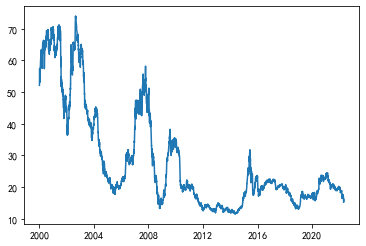

In [3]:
plt.plot(index_value_hist_funddb_df['市盈率'])

In [4]:
bond_zh_us_rate_df = ak.bond_zh_us_rate()
bond_zh_us_rate_df['日期'] = pd.to_datetime(bond_zh_us_rate_df['日期'])
bond_zh_us_rate_df.index = bond_zh_us_rate_df['日期']
print(bond_zh_us_rate_df)

100%|██████████| 17/17 [00:03<00:00,  4.87it/s]

                   日期  中国国债收益率2年  中国国债收益率5年  中国国债收益率10年  中国国债收益率30年  \
日期                                                                    
2022-04-29 2022-04-29     2.3471     2.6136      2.8386      3.3080   
2022-04-28 2022-04-28     2.3677     2.6334      2.8486      3.3229   
2022-04-27 2022-04-27     2.3338     2.6131      2.8411      3.3004   
2022-04-26 2022-04-26     2.3114     2.5894      2.8260      3.2954   
2022-04-25 2022-04-25     2.3009     2.5776      2.8160      3.2953   
...               ...        ...        ...         ...         ...   
1990-12-26 1990-12-26        NaN        NaN         NaN         NaN   
1990-12-24 1990-12-24        NaN        NaN         NaN         NaN   
1990-12-21 1990-12-21        NaN        NaN         NaN         NaN   
1990-12-20 1990-12-20        NaN        NaN         NaN         NaN   
1990-12-19 1990-12-19        NaN        NaN         NaN         NaN   

            中国国债收益率10年-2年  中国GDP年增率  美国国债收益率2年  美国国债收益率5年  美国国债收益率10年  \
日期 

No handles with labels found to put in legend.


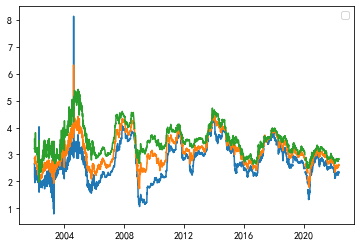

In [5]:
plt.plot(bond_zh_us_rate_df['日期'], bond_zh_us_rate_df['中国国债收益率2年'])
plt.plot(bond_zh_us_rate_df['日期'], bond_zh_us_rate_df['中国国债收益率5年'])
plt.plot(bond_zh_us_rate_df['日期'], bond_zh_us_rate_df['中国国债收益率10年'])
plt.legend()

In [8]:
all_A_2010 = index_value_hist_funddb_df['市盈率']['20100101':]
print(all_A_2010)

日期
2010-01-04    34.79
2010-01-05    35.17
2010-01-06    34.90
2010-01-07    34.14
2010-01-08    34.22
              ...  
2022-04-25    15.45
2022-04-26    15.19
2022-04-27    15.57
2022-04-28    15.61
2022-04-29    16.09
Name: 市盈率, Length: 2976, dtype: float64


In [9]:
bond_yeild_2010 = bond_zh_us_rate_df['中国国债收益率10年']['20100101':]
print(bond_yeild_2010)

日期
2022-04-29    2.8386
2022-04-28    2.8486
2022-04-27    2.8411
2022-04-26    2.8260
2022-04-25    2.8160
               ...  
2010-01-08    3.6614
2010-01-07    3.6543
2010-01-06    3.6425
2010-01-05    3.6606
2010-01-04    3.6603
Name: 中国国债收益率10年, Length: 3285, dtype: float64


In [10]:
stock_zh_index_daily_df = ak.stock_zh_index_daily(symbol="sz399300")
stock_zh_index_daily_df['date'] = pd.to_datetime(stock_zh_index_daily_df['date'])
stock_zh_index_daily_df.index = stock_zh_index_daily_df['date']
print(stock_zh_index_daily_df)
hs_300_2010 = stock_zh_index_daily_df['close']['20100101':]

                 date      open      high       low     close       volume
date                                                                      
2002-01-04 2002-01-04  1316.455  1316.455  1316.455  1316.455            0
2002-01-07 2002-01-07  1302.084  1302.084  1302.084  1302.084            0
2002-01-08 2002-01-08  1292.714  1292.714  1292.714  1292.714            0
2002-01-09 2002-01-09  1272.645  1272.645  1272.645  1272.645            0
2002-01-10 2002-01-10  1281.261  1281.261  1281.261  1281.261            0
...               ...       ...       ...       ...       ...          ...
2022-04-25 2022-04-25  3933.446  3958.210  3814.913  3814.913  16836450200
2022-04-26 2022-04-26  3822.489  3871.850  3773.899  3784.120  15757761100
2022-04-27 2022-04-27  3758.083  3895.731  3757.086  3895.536  17273404600
2022-04-28 2022-04-28  3883.420  3943.435  3873.578  3921.107  15305658600
2022-04-29 2022-04-29  3939.624  4017.428  3898.570  4016.241  17945837700

[4930 rows x 6 columns]


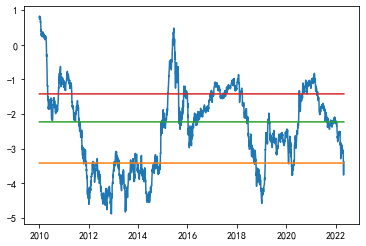

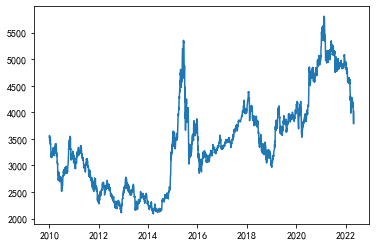

In [11]:
res = -(1 / all_A_2010 * 100 - bond_yeild_2010)
res = res.dropna()
plt.plot(res)
plt.plot(res.index, [-3.412392] * len(res.index))
plt.plot(res.index, [-2.2265] * len(res.index))
plt.plot(res.index, [-1.4194] * len(res.index))
plt.show()
plt.plot(hs_300_2010)

In [12]:
res.describe()

count    2976.000000
mean       -2.377428
std         1.180098
min        -4.877808
25%        -3.413569
50%        -2.229100
75%        -1.423023
max         0.817268
dtype: float64